# Beter verkeersborden herkennen: Het DCNN

Deep Neural Networks (DNN's) zijn neurale netwerken met veel lagen. Deep Convolutional Neural Networks (DCNN's) zijn diepe netwerken ontworpen om convoluties (lokale transformatie functies) te leren. Deze laatste netwerken zijn op het moment de state of the art. 

![Convolutie](images/convolution-calculate.png)

Door convoluties te stapelen kan een netwerk als het filters leren voor complexe objecten (Bijvoorbeeld: Een stoel is een combinatie van stoelpoten en een zetel, een stoelpoot is een combinatie van rechte evenwijdige lijnen)

![Filters](images/Hl2H6.png)

## Tweede poging: Verkeersborden classificeren
In deel I hebben we een netwerk gebouwd dat rond de 65% van de borden herkent. Het netwerk leerde snel, maar de prestaties liepen wat uiteen.

Je zal zien dat met een paar kleine ingrepen we aardig beter gaan presteren.

In [1]:
import os
import random
import skimage.transform
import skimage.data
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Allow image embeding in notebook
%matplotlib inline

def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    images32 = [skimage.transform.resize(image, (32, 32)) for image in images]
    return images32, labels

# Load training and testing datasets.
ROOT_PATH = "./"
train_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Training")
test_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Testing")

images, labels = load_data(train_data_dir)

/home/stijn/anaconda2/envs/tensortut/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# Het DCNN
Een DCNN is in feite een neuraal netwerk met meer dan 2 tussenlagen met minstens een convolutielaag. Maar daarnaast zijn er nog genoeg kleine aanpassingen die het model beter maken, zoals: Tussentijdse pooling en dropout layers. 

Eerst maken we een paar utilfuncties die ons straks gaan helpen:

In [2]:
#To create this model, we're going to need to create a lot of weights and biases. 
#One should generally initialize weights with a small amount of noise for symmetry breaking, 
#and to prevent 0 gradients. Since we're using ReLU neurons, 
#it is also good practice to initialize them with a slightly positive initial bias to avoid "dead neurons". 
#Instead of doing this repeatedly while we build the model, let's create two handy functions to do it for us.

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

#TensorFlow also gives us a lot of flexibility in convolution and pooling operations. 
#How do we handle the boundaries? What is our stride size? In this example, 
#we're always going to choose the vanilla version. 
#Our convolutions uses a stride of one and are zero padded so that the output is the same size as the input. 
#Our pooling is plain old max pooling over 2x2 blocks. To keep our code cleaner, 
#let's also abstract those operations into functions.

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

In [3]:
labels_a = indices_to_one_hot(labels,62)
images_a = np.array(images)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (4575, 62) 
images:  (4575, 32, 32, 3)


 Dan definieren we het deep net, zoals hier onder weergegeven:
        
![DCNN](images/mnist_deep.png)
        
Althans dit wordt gezien als een bescheiden diep netwerk...

In [4]:
# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None,62])
    images = tf.reshape(images_ph, [-1, 32, 32, 3])
    
    #two conv & pooling pairs
    h_conv1 = tf.nn.relu(conv2d(images, weight_variable([3, 3, 3, 32])) + bias_variable([32]))
    h_pool1 = max_pool_2x2(h_conv1)
    h_conv2 = tf.nn.relu(conv2d(h_pool1, weight_variable([5, 5, 32, 64])) + bias_variable([64]))
    h_pool2 = max_pool_2x2(h_conv2)
    
    #Now that the image size has been reduced to 8x8, we add a fully-connected layer with 1024 neurons 
    #to allow processing on the entire image. 
    #We reshape the tensor from the pooling layer into a batch of vectors, 
    #multiply by a weight matrix, add a bias, and apply a ReLU.
    h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, weight_variable([8 * 8 * 64, 1024])) + bias_variable([1024]))

    #To reduce overfitting, we will apply dropout before the readout layer. 
    #We create a placeholder for the probability that a neuron's output is kept during dropout. 
    #This allows us to turn dropout on during training, and turn it off during testing. 
    #TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, 
    #so dropout just works without any additional scaling.
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    #Finally, we add a layer for softmax regression.
    y_conv = tf.matmul(h_fc1_drop, weight_variable([1024, 62])) + bias_variable([62])    
    
    #variables for training and evaluation
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_ph, logits=y_conv))
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(labels_ph, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))   
    
    init = tf.initialize_all_variables()


## Training
We gaan het model nu 200 keer trainen. (We gebruiken de ADAM optimizer om de cross-entropy zo laag mogelijk te krijgen)

In [5]:
# Create a session to run the graph we created.
session = tf.Session(graph=graph)

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run([init])

In [ ]:
for i in range(201): #201
    _, loss_value = session.run([train, cross_entropy], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a, keep_prob: 0.5})
    if i % 30 == 0:
        print("Loss: ", loss_value)

## Evaluatie

Eens kijken of we nu beter scoren

/home/stijn/anaconda2/envs/tensortut/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Truth:        38 Prediction: 39
Truth:        38 Prediction: 39
Truth:        38 Prediction: 39
Truth:        38 Prediction: 39
Truth:        38 Prediction: 40
Truth:        38 Prediction: 40
Truth:        38 Prediction: 35
Truth:        23 Prediction: 28
Truth:        23 Prediction: 28
Truth:        23 Prediction: 28
Truth:        23 Prediction: 28
Truth:        23 Prediction: 32
Truth:        23 Prediction: 28
Truth:        14 Prediction: 16
Truth:        14 Prediction: 7
Truth:        17 Prediction: 7
Truth:        17 Prediction: 7
Truth:        16 Prediction: 14
Truth:        16 Prediction: 18
Truth:        16 Prediction: 14
Truth:        16 Prediction: 18
Truth:        16 Prediction: 14
Truth:        16 Prediction: 18
Truth:        16 Prediction: 14
Truth:        16 Prediction: 18
Truth:        56 Prediction: 57
Truth:        39 Prediction: 38
Truth:        3 Prediction: 13
Truth:        3 Prediction: 13
Truth:        3 Prediction: 13
Truth:        58 Prediction: 35
Truth:        

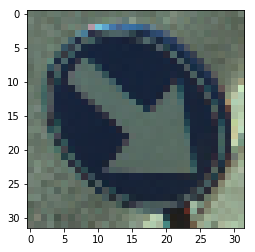

In [35]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)
#test_labels_1h =  indices_to_one_hot(test_labels,62)

predicted = session.run([tf.argmax(y_conv,1)], 
                        feed_dict={images_ph: test_images, keep_prob: 1})[0]

for i in range(len(predicted)):
    if predicted[i] != test_labels[i]:
        plt.imshow(test_images[i])
        print("Truth:        {0} Prediction: {1}".format(test_labels[i], predicted[i]))
    #truth = sample_labels[i]
    #prediction = predicted[i]
    #plt.subplot(5, 2,1+i)
    #plt.axis('off')
    #color='green' if truth == prediction else 'red'
    #plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
    #         fontsize=12, color=color)
    #plt.imshow(sample_images[i])

In [21]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)
test_labels =  indices_to_one_hot(test_labels,62)

# Run predictions against the full test set.
acc = session.run([accuracy], feed_dict={images_ph: test_images, labels_ph: test_labels, keep_prob: 1.0})[0]
print(acc)

/home/stijn/anaconda2/envs/tensortut/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0.934127


In [84]:
# Close the session. This will destroy the trained model.
session.close()